# Analysis of TMA Pointing - Repeatability 

## With Drift

Here, I present the analysis of the pointing repeatability of the same target with the pointing model drift. 
The dataset are for three nights 15th, 17th and 22th March, 2023.

The drift occurs due to the uncertainty of the pointing model on tracking the stars motion.

The data was generated following the notebook:
`LVV-T2732_analysis_repeatability_data`

Full 3.5 degree ofsset test description at: https://sitcomtn-065.lsst.io/

Author: Johnny Esteves

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

## Load Datasets

The residual is the coordinate subtracted by the first exposure. As the time pass the targeted RA/DEC is shifted because of the pointing model uncertainty.

In [2]:
today = '2023-03-09'
df1 = pd.read_csv('tmp/repeatability_w_drift_%s.csv'%today, index_col=0)
df1['night'] = today
# df1

In [3]:
today = '2023-03-17'
df2 = pd.read_csv('tmp/repeatability_w_drift_%s.csv'%today, index_col=0)
df2['night'] = today
df2['Snakes']+= 100 # to make different from night 1
# df2

In [4]:
today = '2023-03-22'
df3 = pd.read_csv('tmp/repeatability_w_drift_%s.csv'%today, index_col=0)
df3['night'] = today
df3['Snakes']+= 200 # to make different from night 1
# df3

In [5]:
df = pd.concat([df1,df2,df3])
df

,dT,Res ra,Res dec,Res az,Res alt,Base Ra,Base Dec,Base Az,Base Alt,Snakes,UTC,night
621,0,0.000000,0.000000,0.000000,0.000000,157.015858,-12.615734,59.615712,60.246587,0,2023-03-09 02:18:39,2023-03-09
622,9,0.183535,0.053499,-169.081900,99.184491,157.015858,-12.615734,59.615712,60.246587,0,2023-03-09 02:18:48,2023-03-09
623,18,0.361134,0.233895,-337.963171,197.857163,157.015858,-12.615734,59.615712,60.246587,0,2023-03-09 02:18:57,2023-03-09
624,26,-0.353344,0.260302,-507.971936,297.228649,157.015858,-12.615734,59.615712,60.246587,0,2023-03-09 02:19:05,2023-03-09
625,42,-1262.142104,12535.449690,-20514.460404,-7126.859571,157.015858,-12.615734,59.615712,60.246587,0,2023-03-09 02:19:21,2023-03-09
...,...,...,...,...,...,...,...,...,...,...,...,...
1224,9069,-25135.793455,251923.645870,-331550.157533,3877.161347,296.927740,-50.120303,134.789068,25.671150,200,2023-03-22 09:21:36,2023-03-22
1225,9078,-25138.189269,251924.542601,-331663.127920,3956.310800,296.927740,-50.120303,134.789068,25.671150,200,2023-03-22 09:21:45,2023-03-22
1226,9086,-25138.070970,251924.649924,-331773.602173,4034.598012,296.927740,-50.120303,134.789068,25.671150,200,2023-03-22 09:21:53,2023-03-22
1227,9095,-25138.147664,251924.724683,-331884.102253,4112.856280,296.927740,-50.120303,134.789068,25.671150,200,2023-03-22 09:22:02,2023-03-22


In [6]:
filter_time = df.dT < 410 # sec
filter_radec = (np.abs(df['Res ra']) < 30)&(np.abs(df['Res dec']) < 30) # arcsec

dfs = df[filter_time&filter_radec].copy()

## Pointing Model

The variance of the ra,dec residuals can be due to the pointing model. Although only three images were taken, the 
stars motion during 15 sec is larger than $0.1$ arcsec. We will verify the offset introduced by the uncertainty of the pointing model.

In [7]:
data = dfs.to_numpy()
dT = data[:,0].astype(int)
res_ra = data[:,1].astype(float)
res_dec = data[:,2].astype(float)

res_az = data[:,3].astype(float)
res_alt = data[:,4].astype(float)

base_az = data[:,7].astype(float)
base_alt = data[:,8].astype(float)

snakes = data[:,-3].astype(int)

In [8]:
dates, counts = np.unique(data[:,-1], return_counts=True)
for di, ci in zip(dates, counts):
    print('The night %s has %i exposures'%(di, ci))

The night 2023-03-09 has 218 exposures
The night 2023-03-17 has 288 exposures
The night 2023-03-22 has 168 exposures


### Drift Residual

The central target of the circle was observed 6 times at different time frames. So, the drift effect due to the pointing model is large, at the order of 10 arsec.

In [9]:
def plot_residual(today):
    plt.figure(figsize=(6,5))
    sel = dfs['night']==today
    plt.scatter(res_ra[sel], res_dec[sel], c=base_alt[sel],cmap='tab20c_r')
    plt.axvline(0,color='k',ls='--')
    plt.axhline(0,color='k',ls='--')
    plt.title('LVV-T2732: %s'%today,fontsize=14)
    plt.xlabel(r'$\delta Ra$ [arcsec]',fontsize=16)
    plt.ylabel(r'$\delta Dec$ [arcsec]',fontsize=16)
    plt.colorbar(label='Alt [deg]')
    plt.savefig('figures/residual_radec_drift_%s.png'%today,dpi=150)

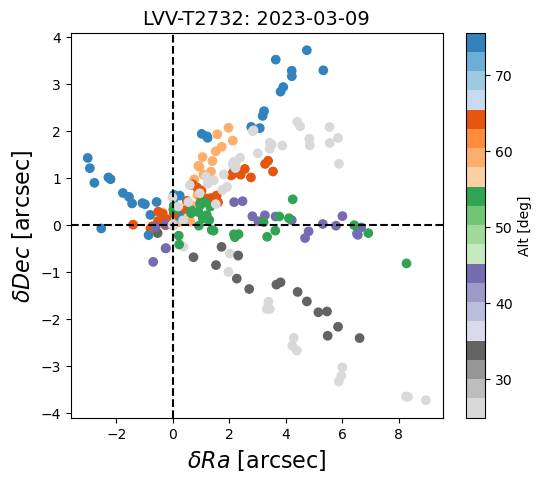

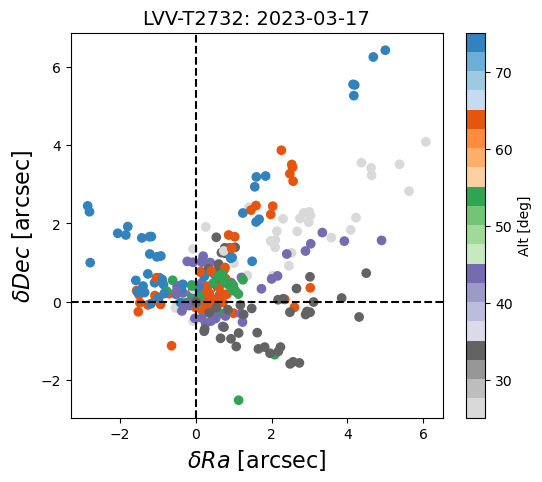

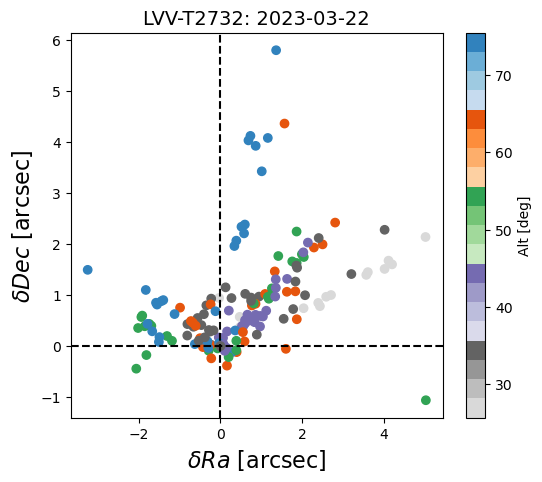

In [10]:
for today in dates:
    plot_residual(today)

### Drift Time Series

In [11]:
def plot_offset_time_series(today):
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,4), sharey='all')
    fig.subplots_adjust(wspace=0.)

    sel = dfs['night']==today
    tt = (np.max(dfs.UTC[sel].astype('datetime64'))-np.min(dfs.UTC[sel].astype('datetime64')))
    tlabel = 'Time Interval: %ih %i min'%(tt.components.hours, tt.components.minutes)
    title = '%s\n'%today+tlabel

    im = ax1.scatter(dT[sel], res_ra[sel], marker='v', c=base_alt[sel], cmap='tab20c_r', label='Ra')
    ax2.scatter(dT[sel], res_dec[sel], marker='^', c=base_alt[sel], cmap='tab20c_r', label='Dec')

    ax1.set_title('Ra')
    ax2.set_title('Dec')
    ax1.set_ylabel('Offset Arcsec', fontsize=16)
    ax1.set_xlabel('Time - $T_0$ [sec]')
    ax2.set_xlabel('Time - $T_0$ [sec]')
    fig.suptitle(title)
    cb = fig.colorbar(im, label='Alt', ax=[ax1,ax2], location='right', fraction=0.05, pad=0.025, extend='both')
    fig.savefig('figures/offset_rate_%s.png'%today, dpi=150)

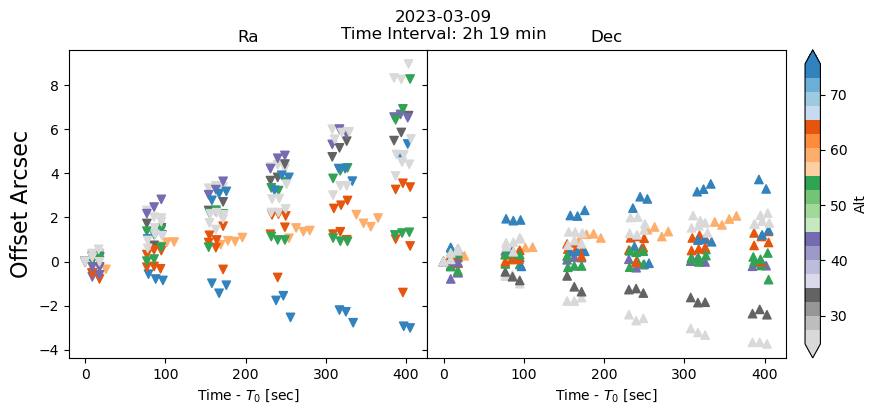

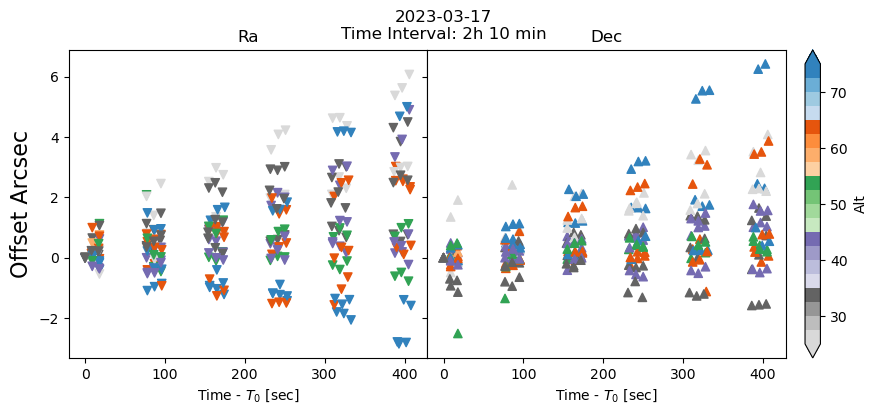

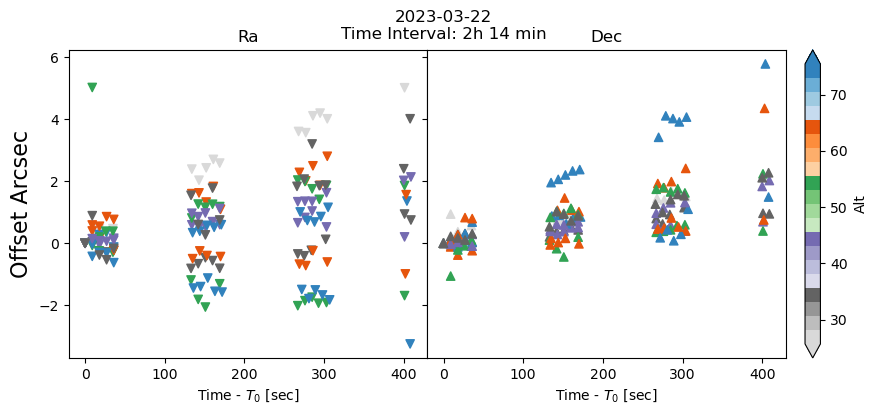

In [12]:
for today in dates:
    plot_offset_time_series(today)

### Offset Rate

The offset is linear with time. So, the offset rate is simply the slope of this linear relation. 

In [13]:
from scipy.optimize import curve_fit
def linear(x,a,b):
    return a+b*x

def get_slope(x,y):
    isnan = np.isnan(y)
    if np.count_nonzero(~isnan)>3:
        coefs, cov = curve_fit(linear, x[~isnan], y[~isnan])
    else:
        coefs = np.array([np.nan, np.nan])
    return coefs


In [14]:
from sklearn import linear_model
# robust linear regression (TheilSenRegressor)

def get_slope2(x,y0):
    isnan = np.isnan(y0)
    y = y0[~isnan]
    X = x[~isnan,np.newaxis]
    if np.count_nonzero(~isnan)>3:
        # Robustly fit linear model with RANSAC algorithm
        ransac = linear_model.TheilSenRegressor()
        ransac.fit(X, y)
        coefs = np.array([ransac.intercept_, ransac.coef_[0]])
    else:
        coefs = np.array([np.nan, np.nan])
        
    return coefs

In [15]:
keys = [np.where(snakes==gi)[0] for gi in np.unique(snakes)]
    
rate1, rate2 = [], []
for ix in keys:
    rate1.append(get_slope2(dT[ix], res_ra[ix]))
    rate2.append(get_slope2(dT[ix], res_dec[ix]))
rate1 = np.array(rate1)
rate2 = np.array(rate2)

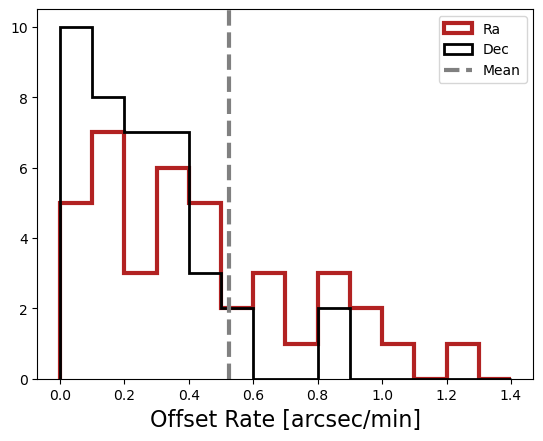

In [24]:
mybins = np.arange(0., 1.5, 0.1)
plt.hist(60*np.abs(rate1)[:,1], bins=mybins, label='Ra', histtype='step', lw=3, color='firebrick')
plt.hist(60*np.abs(rate2)[:,1], bins=mybins, label='Dec', histtype='step', lw=2, color='k')
plt.axvline(np.nanmedian(60*np.hypot(rate1[:,1], rate2[:,1])),ls='--',color='gray',label='Mean',lw=3)
# plt.hist(60*coefs[:,2], bins=mybins, label='Norm', histtype='step', lw=3)
plt.legend()
plt.xlabel('Offset Rate [arcsec/min]',fontsize=16)
plt.savefig('figures/offset_rate.png',dpi=100)

Text(0, 0.5, 'Az')

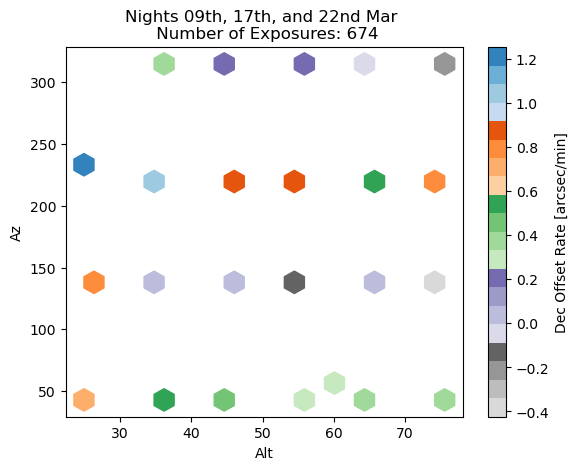

In [25]:
gs, gids, counts = np.unique(snakes, return_index=True, return_counts=True)

title = 'Nights 09th, 17th, and 22nd Mar \n Number of Exposures: %i'%(np.count_nonzero(~np.isnan(res_ra)))
plt.hexbin(base_alt[gids], base_az[gids],60*rate1[:,1], cmap='tab20c_r', gridsize=18, reduce_C_function=np.nanmedian)
plt.colorbar(label='Dec Offset Rate [arcsec/min]')
plt.title(title)
plt.xlabel('Alt')
plt.ylabel('Az')

### Corrections

We can correct for this effect and actually measure the pertubations of the telescope.

In [26]:
res_ra_c0 = res_ra.copy()
res_dec_c0 = res_dec.copy()
for i, ix in enumerate(keys):
    res_ra_c0[ix] -= linear(dT[ix], *rate1[i])
    res_dec_c0[ix] -= linear(dT[ix], *rate2[i])

In [27]:
def mask_outliers(x, n=1.5):
    q1,mean,q3 = np.nanpercentile(x, [16,50,84])
    iqr = (q3-q1)/2.
    plow= q1-n*iqr
    phig= q3+n*iqr
    x = np.where((x>phig)|(x<plow),np.nan,x)
    return x

res_ra_c = mask_outliers(res_ra_c0)
res_dec_c = mask_outliers(res_dec_c0)

Nout = np.count_nonzero(np.isnan(res_ra_c)|np.isnan(res_dec_c))
of_radec = Nout/res_ra.size
print('Outlier Fraction : %.3f'%of_radec)

Outlier Fraction : 0.132


In [28]:
std_ra = np.nanstd(res_ra_c)
std_dec = np.nanstd(res_dec_c)
print('RMS - After Pointing Model Correction')
print('Ra: %.2f arcsec'%std_ra)
print('Dec: %.2f arcsec'%std_dec)

RMS - After Pointing Model Correction
Ra: 0.30 arcsec
Dec: 0.21 arcsec


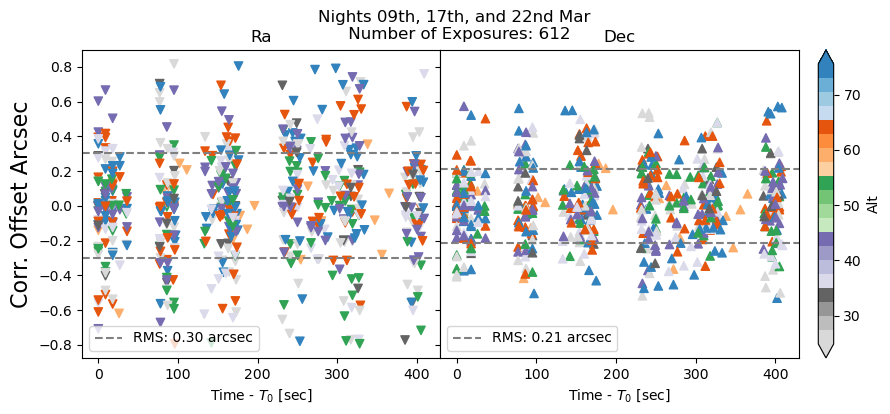

In [30]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,4), sharey='all')
fig.subplots_adjust(wspace=0.)

sel = dfs.index>0
# tt = (np.max(data.UTC[sel])-np.min(data.UTC[sel]))
# tlabel = 'Time Interval: %ih %i min'%(tt.components.hours, tt.components.minutes)
# title = '%s - Sequences 600:910\n'%today+tlabel

title = 'Nights 09th, 17th, and 22nd Mar \n Number of Exposures: %i'%(np.count_nonzero(~np.isnan(res_ra_c[sel])))

im = ax1.scatter(dT[sel], res_ra_c[sel], marker='v', c=base_alt[sel], cmap='tab20c_r')
ax2.scatter(dT[sel], res_dec_c[sel], marker='^', c=base_alt[sel], cmap='tab20c_r')
ax1.axhline(std_ra, ls='--', color='gray',label='RMS: %.2f arcsec'%std_ra)
ax2.axhline(std_dec, ls='--', color='gray',label='RMS: %.2f arcsec'%std_dec)
ax1.axhline(-std_ra, ls='--', color='gray')
ax2.axhline(-std_dec, ls='--', color='gray')
ax1.legend(loc=3)
ax2.legend(loc=3)
ax1.set_title('Ra')
ax2.set_title('Dec')
ax1.set_ylabel('Corr. Offset Arcsec', fontsize=16)
ax1.set_xlabel('Time - $T_0$ [sec]')
ax2.set_xlabel('Time - $T_0$ [sec]')
fig.suptitle(title)
cb = fig.colorbar(im, label='Alt', ax=[ax1,ax2], location='right', fraction=0.05, pad=0.025, extend='both')
fig.savefig('figures/corrected_offset_rate.png', dpi=200)

After correction, we see a residual RA/DEC precision of 0.30/0.21 arcsec. The higher variance is driven by the linear model uncertainty. For instance, in some circles the relation has some non-linear variations.  Overall, this result is equivalent to the without drift analysis. 

## Outliers Analysis

TBD

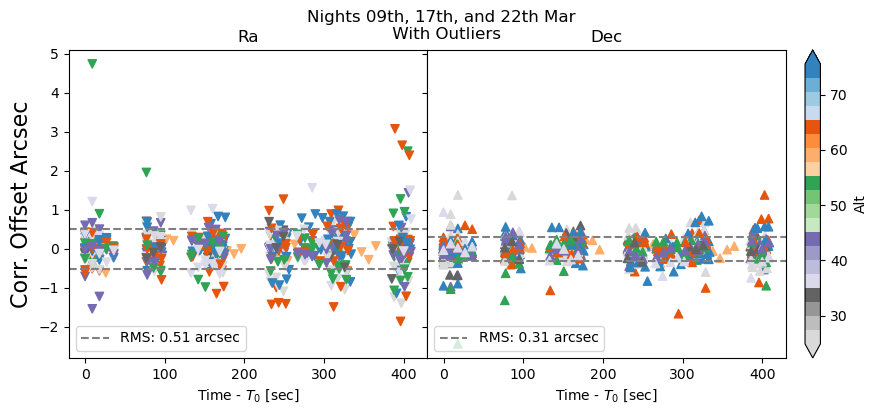

In [31]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,4), sharey='all')
fig.subplots_adjust(wspace=0.)

sel = dfs.index>0
# tt = (np.max(data.UTC[sel])-np.min(data.UTC[sel]))
# tlabel = 'Time Interval: %ih %i min'%(tt.components.hours, tt.components.minutes)
# title = '%s - Sequences 600:910\n'%today+tlabel

std_ra0 = np.nanstd(res_ra_c0)
std_dec0 = np.nanstd(res_dec_c0)

title = 'Nights 09th, 17th, and 22th Mar \n With Outliers'

im = ax1.scatter(dT[sel], res_ra_c0[sel], marker='v', c=base_alt[sel], cmap='tab20c_r')
ax2.scatter(dT[sel], res_dec_c0[sel], marker='^', c=base_alt[sel], cmap='tab20c_r')
ax1.axhline(std_ra0, ls='--', color='gray',label='RMS: %.2f arcsec'%std_ra0)
ax2.axhline(std_dec0, ls='--', color='gray',label='RMS: %.2f arcsec'%std_dec0)
ax1.axhline(-std_ra0, ls='--', color='gray')
ax2.axhline(-std_dec0, ls='--', color='gray')
ax1.legend(loc=3)
ax2.legend(loc=3)
ax1.set_title('Ra')
ax2.set_title('Dec')
ax1.set_ylabel('Corr. Offset Arcsec', fontsize=16)
ax1.set_xlabel('Time - $T_0$ [sec]')
ax2.set_xlabel('Time - $T_0$ [sec]')
fig.suptitle(title)
cb = fig.colorbar(im, label='Alt', ax=[ax1,ax2], location='right', fraction=0.05, pad=0.025, extend='both')
fig.savefig('figures/corrected_offset_rate_wOutliers.png', dpi=150)